In [1]:
import numpy as np
import os
import torch.optim as optim
from torch import nn
from copy import deepcopy
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random

def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

class ARC_Dataset(Dataset):
    def __init__(self, challenges, solution, task_data_num=1, example_data_num=10):
        challenges = load_json(challenges)
        solution = load_json(solution)
        self.data = []
        self.task_data_num = task_data_num
        self.example_data_num = example_data_num
        
        for key, value in challenges.items():
            for i in range(len(value['test'])):
                task_input = value['test'][i]['input']
                task_output = solution[key][i]
                example_input = [ex['input'] for ex in value['train']]
                example_output = [ex['output'] for ex in value['train']]
                
                # 데이터프레임으로 변환될 데이터를 리스트에 저장
                self.data.append({
                    'id': key,
                    'input': task_input,
                    'output': task_output,
                    'ex_input': example_input,
                    'ex_output': example_output
                })

        # 리스트를 데이터프레임으로 변환
        self.df = pd.DataFrame(self.data)
        
    def __len__(self):
        return len(self.df)
    
    def pad_to_30x30(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 30 - h)
        pad_w = max(0, 30 - w)
        
        # 좌우 및 상하 패딩을 반반씩 나눠서 적용
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        
        return tensor

    def mapping_input(self, tensor):
        mapping = {
            1: random.randint(1, 10),
            2: random.randint(11, 20),
            3: random.randint(21, 30),
            4: random.randint(31, 40),
            5: random.randint(41, 50),
            6: random.randint(51, 60),
            7: random.randint(61, 70),
            8: random.randint(71, 80),
            9: random.randint(81, 90),
            10: random.randint(91, 100)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor
    
    def noise_input(self, tensor):
        mapping = {
            1: 1+ np.random.normal(0, 1),
            2: 2+ np.random.normal(0, 1),
            3: 3+ np.random.normal(0, 1),
            4: 4+ np.random.normal(0, 1),
            5: 5+ np.random.normal(0, 1),
            6: 6+ np.random.normal(0, 1),
            7: 7+ np.random.normal(0, 1),
            8: 8+ np.random.normal(0, 1),
            9: 9+ np.random.normal(0, 1),
            10: 10+ np.random.normal(0, 1)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor
    
    def augment_example_output(self, tensor):
        # 출력 데이터 증강 (아직 구현 필요)
        return tensor

    def __getitem__(self, idx):
        #print(idx)
        '''
        1. 데이터의 인덱스(idx)를 받아서 해당 인덱스(idx)의 데이터를 불러온다.
        2. 데이터를 텐서형으로 변환하며, 클래스 번호에 +1을 해준다. (제로 패딩을 위해)
        3. 패딩을 추가한다. (30x30 zero padding)
        4. 샘플에 증강을 수행한다.
            4-1. task_input은 증강된 데이터가 self.task_data_num 개가 될 때까지 증강을 수행한다.
            4-2. example_input은 증강된 데이터가 self.example_data_num 개가 될 때까지 증강을 수행한다.
        5. 증강된 데이터를 스택으로 변환한다.
        6. 반환한다.
        
        최종 출력 형태:
        [task_number, inner_batch_size, channel, height, width]
        '''
        task = self.df.iloc[idx]
        
        # task_input과 task_output 변환 및 패딩 추가
        task_input = [self.pad_to_30x30((torch.tensor(task['input'],dtype=torch.float32) + 1))]
        task_output = [self.pad_to_30x30((torch.tensor(task['output'],dtype=torch.float32) + 1))]
        
        # 예제 입력과 출력 변환 및 패딩 추가
        example_input = [self.pad_to_30x30(torch.tensor(ex,dtype=torch.float32) + 1) for ex in task['ex_input']]
        example_output = [self.pad_to_30x30(torch.tensor(ex,dtype=torch.float32) + 1) for ex in task['ex_output']]
        
        task_size = len(task_input)
        for i in range(self.task_data_num):
            random_index = random.randint(0, task_size - 1)
            task_input.append(self.mapping_input(task_input[random_index]))
            # task_input.append(task_input[random_index])
            # task_output.append(task_output[0])
            task_output.append(self.mapping_input(task_output[random_index]))
        
        size = len(example_input)
        for i in range(self.example_data_num):
            random_index = random.randint(0, size - 1)
            # example_input.append(self.mapping_input(example_input[random_index]))
            example_input.append(example_input[random_index])
            example_output.append(example_output[random_index])
            # example_output.append(self.mapping_input(example_output[random_index]))
        
        task_input = task_input[task_size:]
        task_output = task_output[task_size:]
        task_input = torch.stack(task_input)
        task_output = torch.stack(task_output)
        
        example_input = example_input[size:]
        example_output = example_output[size:]
        example_input = torch.stack(example_input)
        example_output = torch.stack(example_output)
        
        # 최종 출력 형태: [task_number, inner_batch_size, channel, height, width]
        return task_input, task_output, example_input, example_output
# 사용 예제
train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

ti, to, ei, eo = next(iter(train_loader))

In [2]:
print(ti.shape, to.shape, ei.shape, eo.shape)

torch.Size([10, 1, 1, 30, 30]) torch.Size([10, 1, 1, 30, 30]) torch.Size([10, 10, 1, 30, 30]) torch.Size([10, 10, 1, 30, 30])


In [2]:
task_data_num = 10
inner_epcohs = 10
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=task_data_num, shuffle=True)
data = next(iter(train_loader))

print(data[0][1].shape)
print(data[1][1].shape)
print(data[2][0].shape)
print(data[3][0].shape)

Inner_model = Model()
for task_number in range(task_numbers):
    
    ex_input = data[2][task_number]
    ex_output = data[3][task_number]
    pred = Inner_model(ex_input)
    loss = criterion(pred, ex_output)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
for task_number in range(task_numbers):
    
    task_input = data[0][task_number]
    task_output = data[1][task_number]
    
    pred = Inner_model(task_input)
    loss = criterion(pred, task_output)
    total_loss += loss.item()


    
    # for j in range(inner_loop):
            
    #print(ti[i].shape, to[i].shape, ei[i].shape, eo[i].shape)
    

torch.Size([1, 1, 30, 30])
torch.Size([1, 1, 30, 30])
torch.Size([10, 1, 30, 30])
torch.Size([10, 1, 30, 30])


NameError: name 'Model' is not defined

torch.Size([1, 8, 30, 30])
torch.Size([1, 8, 30, 30])
(1, 8, 30, 30)
(30, 30)


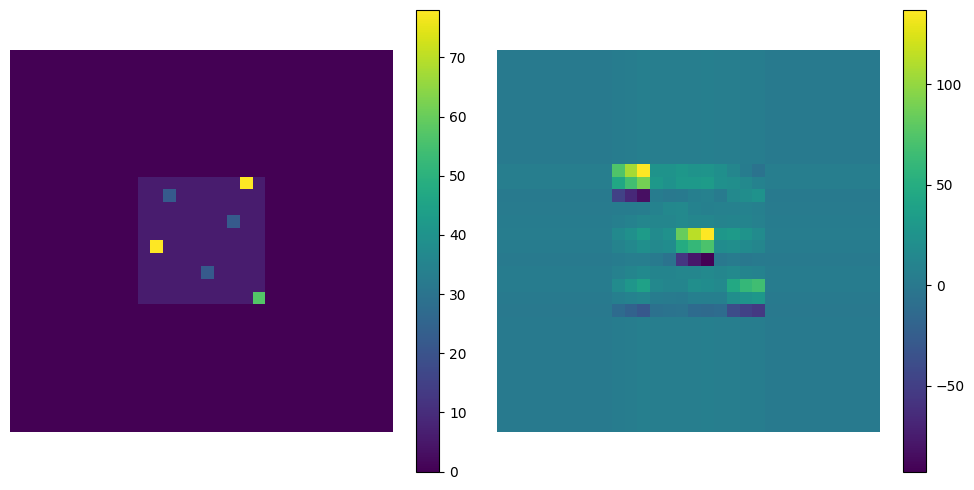

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
torch.Size([1, 8, 30, 30])
FLOPs: 73.440K
파라미터 수: 108.000B
torch.Size([1, 8, 30, 30])


Layer (type:depth-idx)                   Output Shape              Param #
AA                                       [1, 8, 30, 30]            --
├─Conv2d: 1-1                            [1, 1, 30, 32]            4
├─Conv2d: 1-2                            [1, 8, 30, 30]            32
├─Conv2d: 1-3                            [1, 1, 30, 32]            4
├─Conv2d: 1-4                            [1, 8, 30, 30]            32
├─Conv2d: 1-5                            [1, 1, 30, 32]            4
├─Conv2d: 1-6                            [1, 8, 30, 30]            32
Total params: 108
Trainable params: 108
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.00
Estimated Total Size (MB): 0.20

In [228]:
import torch
from einops import rearrange
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

class AA(nn.Module):
    def __init__(self,embedding_dim=8):
        super(AA, self).__init__()
        # self.cq = nn.Conv2d(1, embedding_dim, 3,1,1)
        # self.ck = nn.Conv2d(1, embedding_dim, 3,1,1)
        # self.cv = nn.Conv2d(1, embedding_dim, 3,1,1)
        self.cq1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), stride=1, padding=1, groups=1) 
        self.cq2 = nn.Conv2d(in_channels=1, out_channels=embedding_dim, kernel_size=(1,3), stride=1, padding=0)
        self.ck1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), stride=1, padding=1, groups=1) 
        self.ck2 = nn.Conv2d(in_channels=1, out_channels=embedding_dim, kernel_size=(1,3), stride=1, padding=0)
        self.cv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), stride=1, padding=1, groups=1) 
        self.cv2 = nn.Conv2d(in_channels=1, out_channels=embedding_dim, kernel_size=(1,3), stride=1, padding=0)
    def forward(self, x):
        # q = self.cq(x)
        # k = self.ck(x)
        # v = self.cv(x)
        q = self.cq2(self.cq1(x))
        k = self.ck2(self.ck1(x))
        v = self.cv2(self.cv1(x))
        qk = torch.matmul(q, k.transpose(2, 3))
        print(qk.shape)
        qk2 = F.softmax(qk, dim=-1)
        x = torch.matmul(qk2, v)
        
        return x, qk
    
model = AA()
output, attn_weights = model(ti[1])
print(output.shape)

attn_weights = attn_weights.detach().cpu().numpy()  
print(attn_weights.shape)
attn_weights = attn_weights[0, 0]
print(attn_weights.shape)
#attn_weights = rearrange(attn_weights, '(h w) c -> c h w',h = 30)
# 어텐션 가중치를 시각화하기 위한 히트맵
plt.figure(figsize=(10, 5))
input_image = ti[1,0,0]
# 첫 번째 서브플롯: 입력 이미지
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='viridis')
plt.colorbar()
plt.axis('off')

# 두 번째 서브플롯: 어텐션 가중치 히트맵
plt.subplot(1, 2, 2)
plt.imshow(attn_weights, cmap='viridis')

plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

from thop import profile
from thop import clever_format


# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(ti[1],))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    
from torchinfo import summary

summary(model, input_size=(1, 1, 30, 30))

torch.Size([1, 8, 30, 30])
torch.Size([1, 8, 30, 30])
(1, 8, 30, 30)
(30, 30)


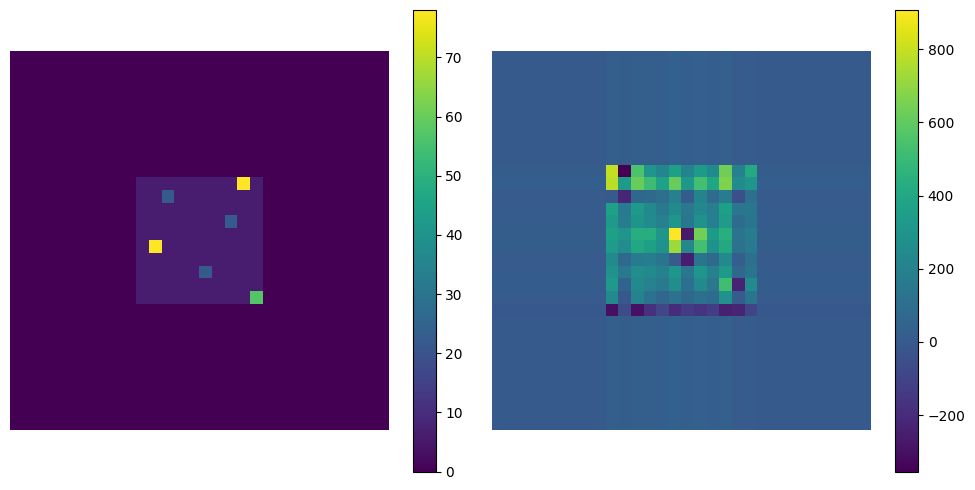

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
torch.Size([1, 8, 30, 30])
FLOPs: 194.400K
파라미터 수: 240.000B
torch.Size([1, 8, 30, 30])


Layer (type:depth-idx)                   Output Shape              Param #
AA                                       [1, 8, 30, 30]            --
├─Conv2d: 1-1                            [1, 8, 30, 30]            80
├─Conv2d: 1-2                            [1, 8, 30, 30]            80
├─Conv2d: 1-3                            [1, 8, 30, 30]            80
Total params: 240
Trainable params: 240
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.18

In [212]:
import torch
from einops import rearrange
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

class AA(nn.Module):
    def __init__(self,embedding_dim=8):
        super(AA, self).__init__()
        self.cq = nn.Conv2d(1, embedding_dim, 3,1,1)
        self.ck = nn.Conv2d(1, embedding_dim, 3,1,1)
        self.cv = nn.Conv2d(1, embedding_dim, 3,1,1)
        # self.cq1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), stride=1, padding=1, groups=1) 
        # self.cq2 = nn.Conv2d(in_channels=1, out_channels=embedding_dim, kernel_size=(1,3), stride=1, padding=0)
        # self.ck1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), stride=1, padding=1, groups=1) 
        # self.ck2 = nn.Conv2d(in_channels=1, out_channels=embedding_dim, kernel_size=(1,3), stride=1, padding=0)
        # self.cv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), stride=1, padding=1, groups=1) 
        # self.cv2 = nn.Conv2d(in_channels=1, out_channels=embedding_dim, kernel_size=(1,3), stride=1, padding=0)
    def forward(self, x):
        q = self.cq(x)
        k = self.ck(x)
        v = self.cv(x)
        # q = self.cq2(self.cq1(x))
        # k = self.ck2(self.ck1(x))
        # v = self.cv2(self.cv1(x))
        qk = torch.matmul(q, k.transpose(2, 3))
        print(qk.shape)
        qk2 = F.softmax(qk, dim=-1)
        x = torch.matmul(qk2, v)
        
        return x, qk
    
model = AA()
output, attn_weights = model(ti[1])
print(output.shape)

attn_weights = attn_weights.detach().cpu().numpy()  
print(attn_weights.shape)
attn_weights = attn_weights[0, 0]
print(attn_weights.shape)
#attn_weights = rearrange(attn_weights, '(h w) c -> c h w',h = 30)
# 어텐션 가중치를 시각화하기 위한 히트맵
plt.figure(figsize=(10, 5))
input_image = ti[1,0,0]
# 첫 번째 서브플롯: 입력 이미지
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='viridis')
plt.colorbar()
plt.axis('off')

# 두 번째 서브플롯: 어텐션 가중치 히트맵
plt.subplot(1, 2, 2)
plt.imshow(attn_weights, cmap='viridis')

plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

from thop import profile
from thop import clever_format


# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(ti[1],))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    
from torchinfo import summary

summary(model, input_size=(1, 1, 30, 30))

torch.Size([1, 1, 30, 30])
torch.Size([1, 8, 30, 30])
torch.Size([1, 900, 900])
(1, 900, 900)
(900, 900)


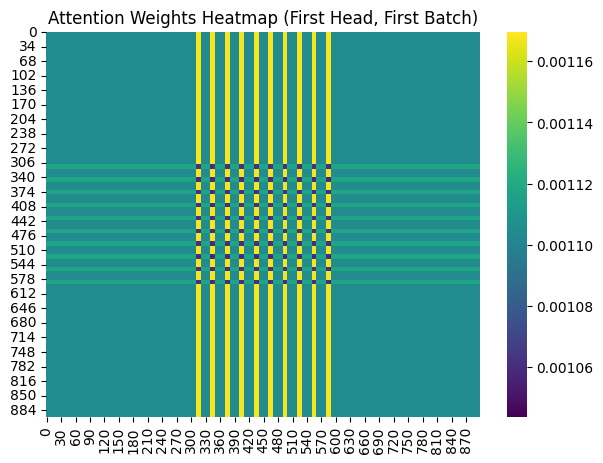

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 554.400K
파라미터 수: 616.000B


Layer (type:depth-idx)                   Output Shape              Param #
NewNet                                   [1, 8, 30, 30]            --
├─Conv2d: 1-1                            [1, 8, 30, 30]            16
├─LayerNorm: 1-2                         [900, 1, 8]               16
├─MultiheadAttention: 1-3                [900, 1, 8]               288
├─LayerNorm: 1-4                         [900, 1, 8]               16
├─Sequential: 1-5                        [900, 1, 8]               --
│    └─Linear: 2-1                       [900, 1, 32]              288
│    └─GELU: 2-2                         [900, 1, 32]              --
│    └─Dropout: 2-3                      [900, 1, 32]              --
│    └─Linear: 2-4                       [900, 1, 8]               264
│    └─Dropout: 2-5                      [900, 1, 8]               --
├─LayerNorm: 1-6                         [900, 1, 8]               16
Total params: 904
Trainable params: 904
Non-trainable params: 0
Total mult-adds (U

In [249]:
import torch
from einops import rearrange
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

class NewNet(nn.Module):
    def __init__(self, embed_dim, mlp_dim=256, dropout=0.1):
        super(NewNet, self).__init__()
        self.embedding = nn.Conv2d(1, embed_dim, 1)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, 8)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.layernorm3 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        height = x.shape[2]
        x = self.embedding(x)
        #print(x.shape)
        x = rearrange(x, 'b c h w -> b (h w) c')
        #print(x.shape)
        x = x.permute(1, 0, 2)
        #print(x.shape)
        x = self.layernorm1(x)
        #print(x.shape)
        # 어텐션 가중치(attn_weights)와 함께 출력 받음
        x, attn_weights = self.attn(x, x, x)
        #print(x.shape)
        #print(attn_weights.shape)
        x = self.layernorm2(x)
        x = self.mlp(x)
        x = self.layernorm3(x)

        x = rearrange(x, '(h w) b c -> b c h w', h=height)
        return x, attn_weights

# Create an instance of the network
net = NewNet(embed_dim=8,mlp_dim=8*4,dropout=0.1)

# Pass the input tensor through the network
print(ti[1].shape)
output_tensor, attn_weights = net(ti[1])
print('======')
print(output_tensor.shape)  # Output tensor의 크기 확인
print(attn_weights.shape)   # 어텐션 가중치의 크기 확인

# 어텐션 가중치의 크기를 확인하면 [batch_size, num_heads, seq_len, seq_len] 형태여야 함
# 예를 들어, [1, 8, 900, 900] 이 되어야 함
# 시각화를 위해 첫 번째 배치와 첫 번째 헤드의 어텐션 가중치를 사용합니다
attn_weights = attn_weights.detach().cpu().numpy()  
print(attn_weights.shape)
attn_weights = attn_weights[0]
print(attn_weights.shape)
#attn_weights = rearrange(attn_weights, '(h w) c -> c h w',h = 30)
# 어텐션 가중치를 시각화하기 위한 히트맵
plt.figure(figsize=(7, 5))
sns.heatmap(attn_weights, cmap='viridis')
plt.title('Attention Weights Heatmap (First Head, First Batch)')
plt.show()


# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(net, inputs=(ti[1],))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    
from torchinfo import summary

summary(net, input_size=(1, 1, 30, 30))

304
252
308
139
38
111
87
114
200
205


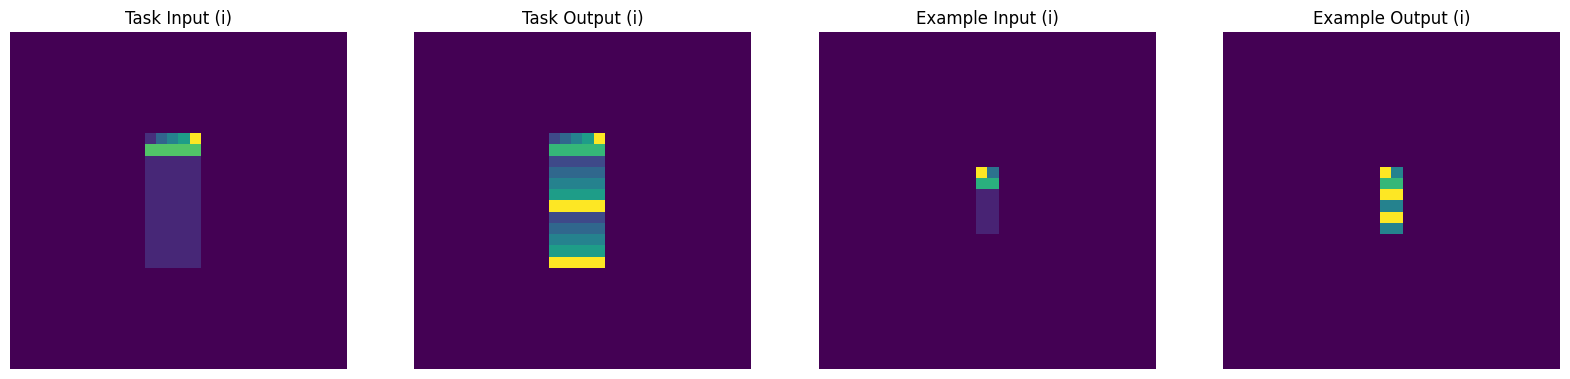

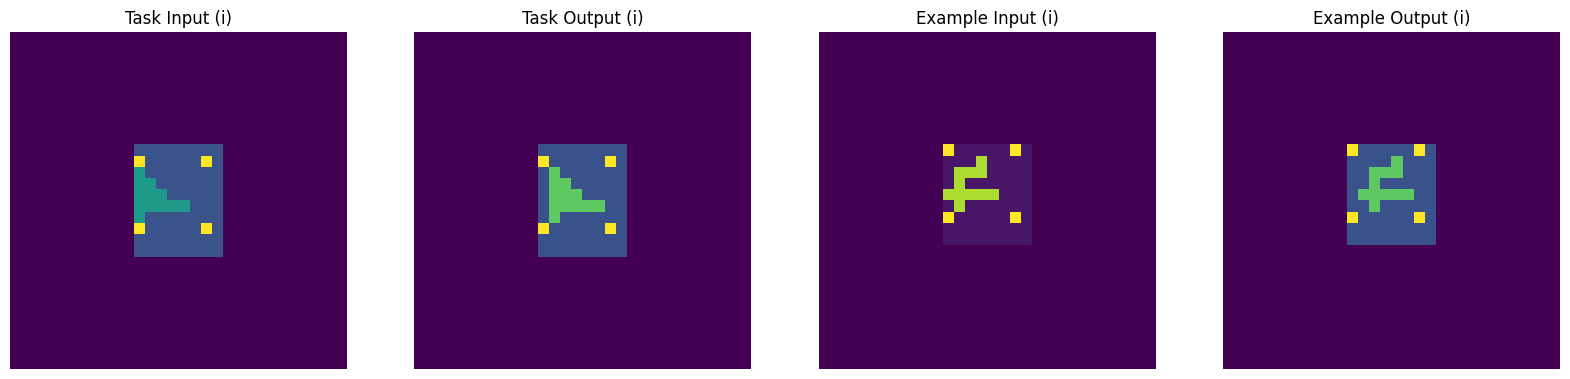

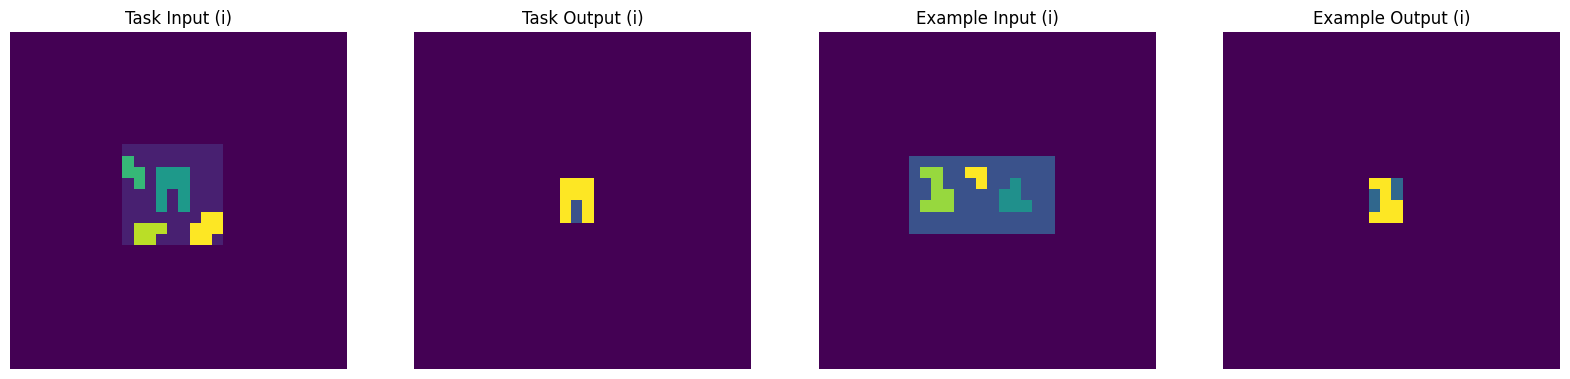

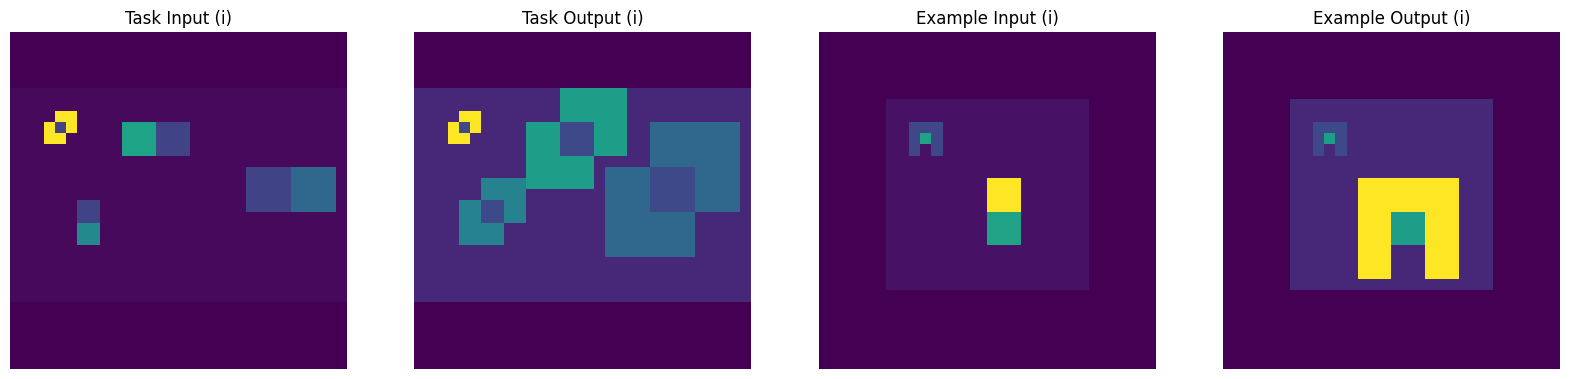

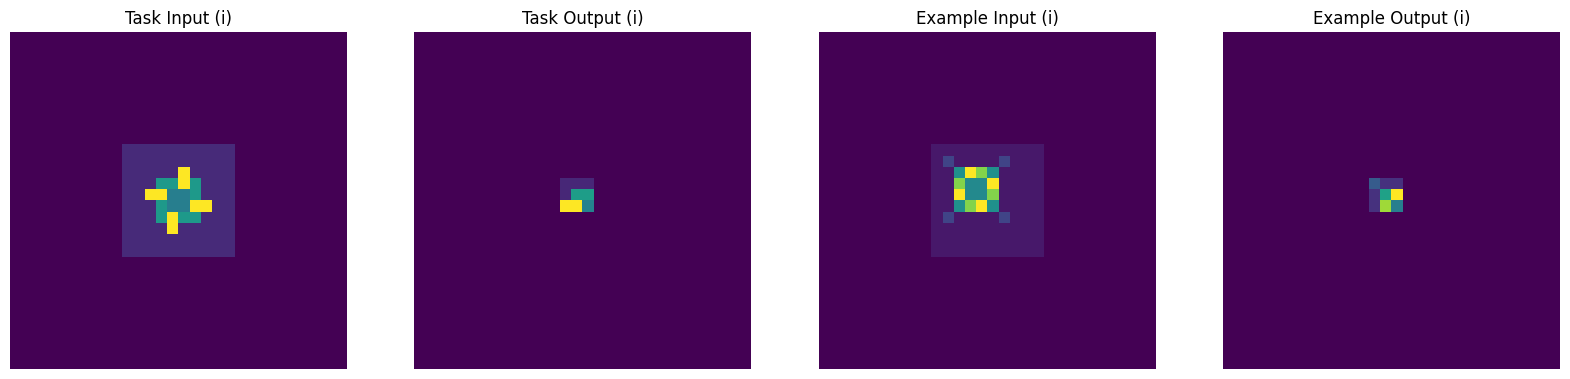

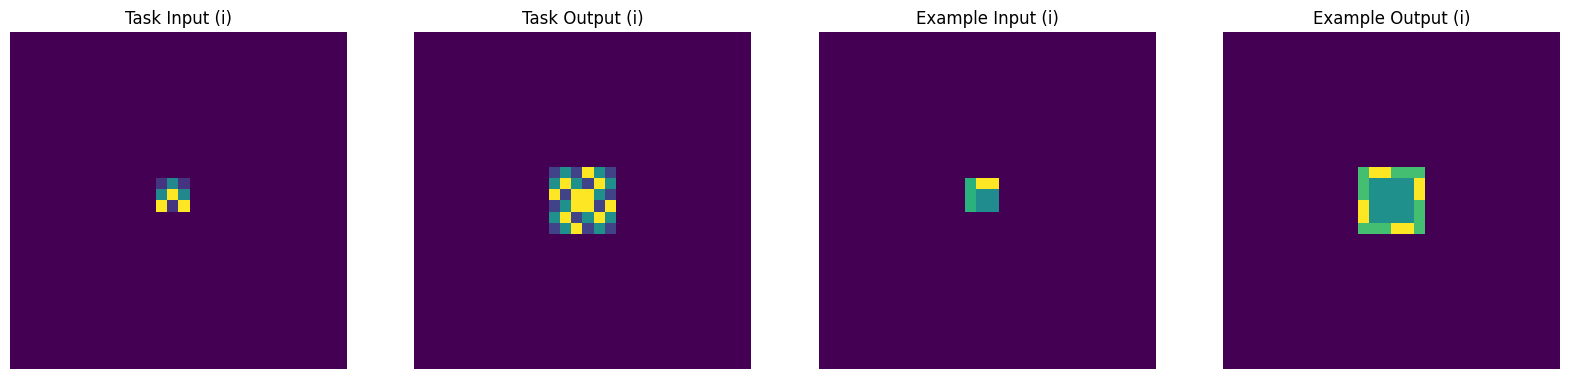

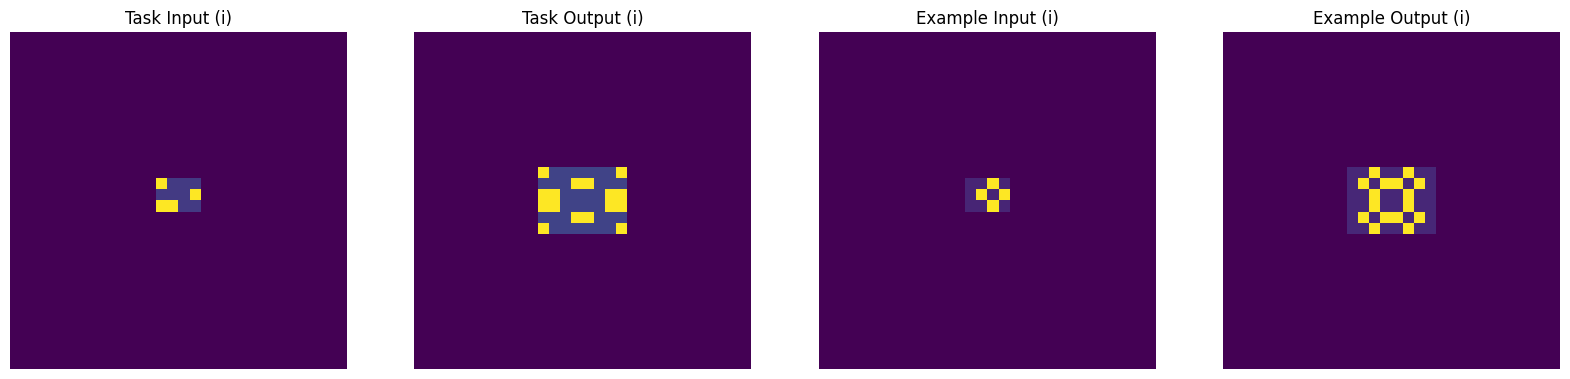

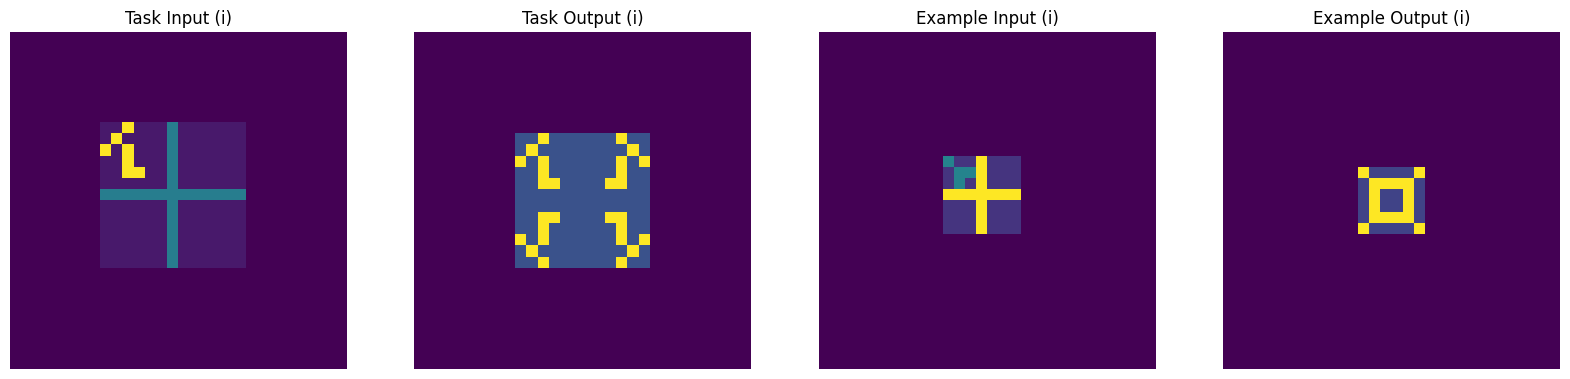

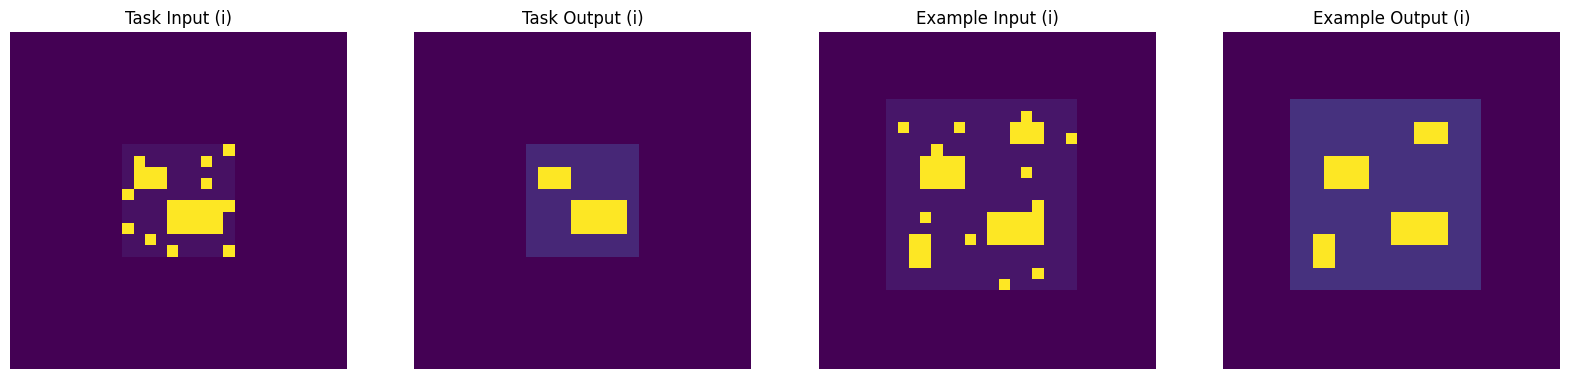

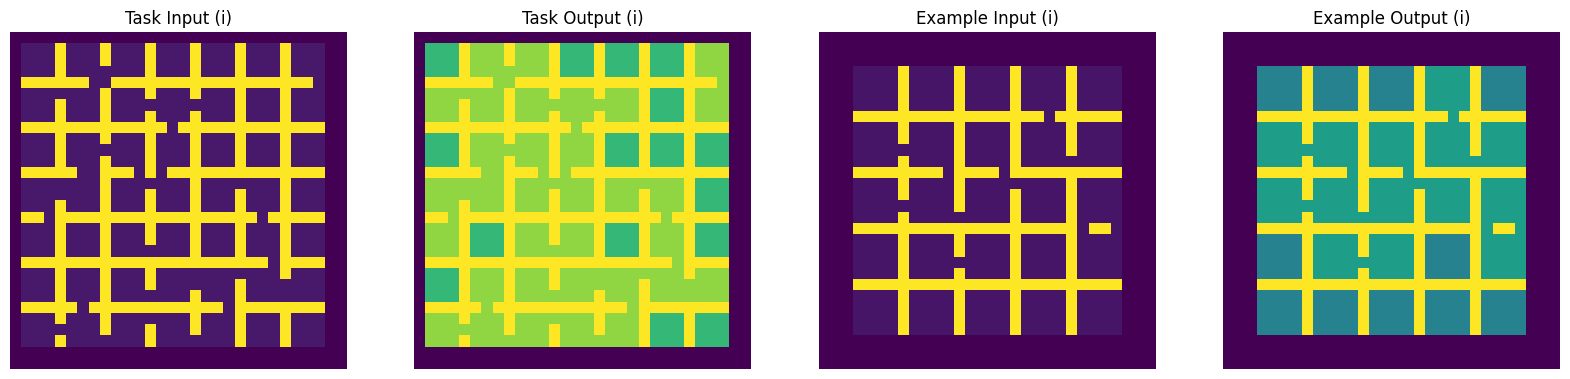

In [19]:
import matplotlib.pyplot as plt
task_number = 10
ti, to, ei, eo = next(iter(train_loader))
for i in range(task_number):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    axes[0].imshow(ti[i,:].squeeze(0,1).numpy())
    axes[0].set_title("Task Input (i)")
    axes[0].axis('off')

    axes[1].imshow(to[i,:].squeeze(0,1).numpy())
    axes[1].set_title("Task Output (i)")
    axes[1].axis('off')

    axes[2].imshow(ei[i,:].squeeze(0,1)[0,:].numpy())
    axes[2].set_title("Example Input (i)")
    axes[2].axis('off')

    axes[3].imshow(eo[i,:].squeeze(0,1)[0,:].numpy())
    axes[3].set_title("Example Output (i)")
    axes[3].axis('off')
    
    plt.show()
    

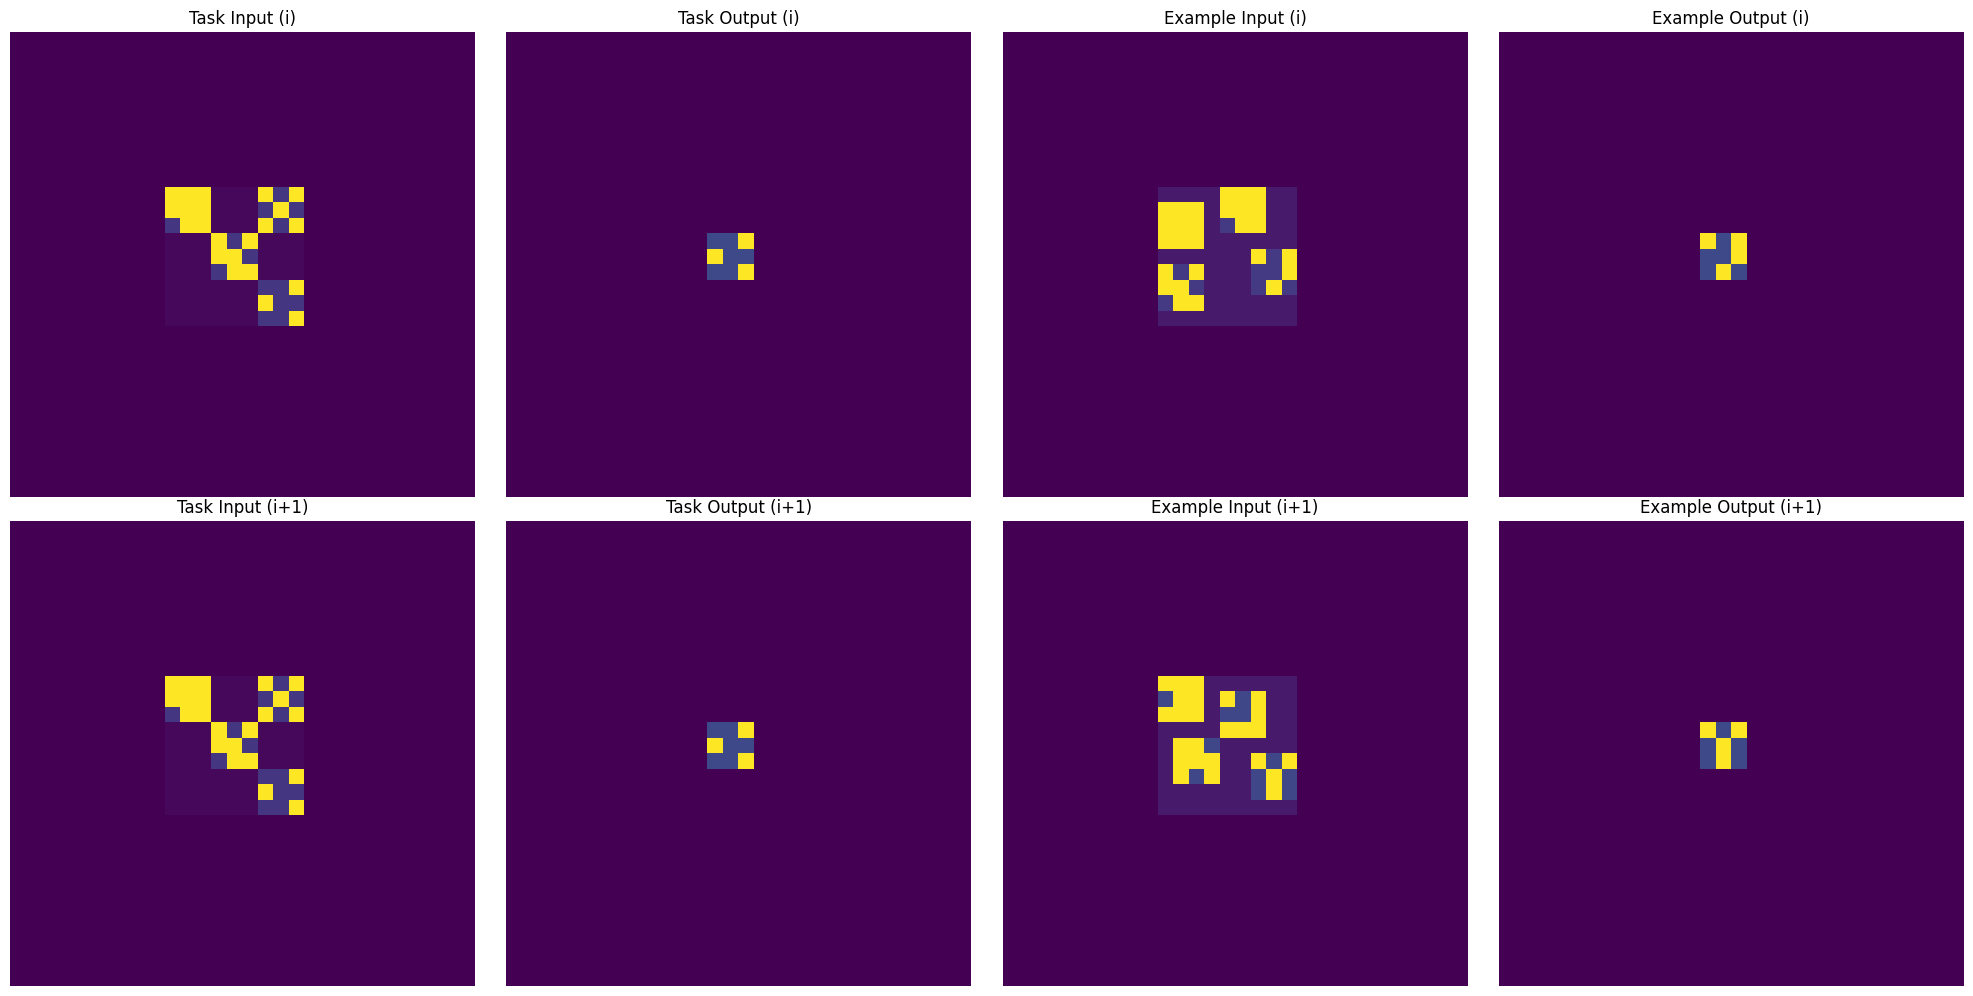

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [11]:


i = 5
# 이미지들을 한 줄로 출력하기 위해 2x4의 subplots 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# 첫 번째 행: i 번째 이미지
axes[0, 0].imshow(t_i[0, 0, 0].numpy())
axes[0, 0].set_title("Task Input (i)")
axes[0, 0].axis('off')

axes[0, 1].imshow(t_o[0, 0, 0].numpy())
axes[0, 1].set_title("Task Output (i)")
axes[0, 1].axis('off')

axes[0, 2].imshow(e_i[0, i, 0].numpy())
axes[0, 2].set_title("Example Input (i)")
axes[0, 2].axis('off')

axes[0, 3].imshow(e_o[0, i, 0].numpy())
axes[0, 3].set_title("Example Output (i)")
axes[0, 3].axis('off')

# 두 번째 행: i+1 번째 이미지
axes[1, 0].imshow(t_i[0, 0, 0].numpy())
axes[1, 0].set_title("Task Input (i+1)")
axes[1, 0].axis('off')

axes[1, 1].imshow(t_o[0, 0, 0].numpy())
axes[1, 1].set_title("Task Output (i+1)")
axes[1, 1].axis('off')

axes[1, 2].imshow(e_i[0, i + 1, 0].numpy())
axes[1, 2].set_title("Example Input (i+1)")
axes[1, 2].axis('off')

axes[1, 3].imshow(e_o[0, i + 1, 0].numpy())
axes[1, 3].set_title("Example Output (i+1)")
axes[1, 3].axis('off')

# 그래프 간 간격 조정
plt.tight_layout()
plt.show()

print(t_i[0, 0, 0].numpy())

In [3]:
import torch
import random

tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print("Original Tensor:")
print(tensor)

# 랜덤 매핑 생성
mapping = {
    1: random.randint(1, 10),
    2: random.randint(11, 20),
    3: random.randint(21, 30),
    4: random.randint(31, 40),
    5: random.randint(41, 50),
    6: random.randint(51, 60),
    7: random.randint(61, 70),
    8: random.randint(71, 80),
    9: random.randint(81, 90)
}

# 기존 값과 충돌을 방지하기 위한 임시 매핑 값 설정

temp_tensor = tensor.clone()
for k in mapping:
    temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

# 최종 매핑 적용
for k, v in mapping.items():
    temp_tensor[temp_tensor == -k] = v

print("Augmented Tensor:")
print(temp_tensor)


Original Tensor:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
Augmented Tensor:
tensor([[ 8, 17, 21],
        [32, 50, 54],
        [66, 80, 86]])


In [4]:
import torch

def remove_padding(output):
    # 텐서가 2차원인지 3차원인지 확인
    if output.dim() == 2:
        # 2차원 텐서의 경우
        non_zero_indices = torch.nonzero(output)
        if non_zero_indices.nelement() == 0:
            return torch.tensor([])

        # 최소 및 최대 인덱스 계산 (행과 열)
        min_y, min_x = non_zero_indices[:, 0].min().item(), non_zero_indices[:, 1].min().item()
        max_y, max_x = non_zero_indices[:, 0].max().item(), non_zero_indices[:, 1].max().item()

        # 패딩이 제거된 부분을 자르기
        output_cleaned = output[min_y:max_y + 1, min_x:max_x + 1]
    
    else:
        raise ValueError("지원되지 않는 텐서 차원입니다. 2D 또는 3D 텐서만 지원됩니다.")
    
    return output_cleaned

# 사용 예제
asd = e_i[0][0]  # 3D 텐서일 것으로 예상
edd = remove_padding(asd)
print(edd.shape)  # 패딩이 제거된 실제 크기가 출력됨


ValueError: 지원되지 않는 텐서 차원입니다. 2D 또는 3D 텐서만 지원됩니다.

|id|input|output|example_input|example_output|
|-|-|-|-|-|
1|[[1]]|[[2]]|[[],[],[]]|[[1],[2],[3]]|
1|[[1,2],[3,4],[5,6]]|[[2,3],[4,5],[6,7]]|[[],[],[]]|[[1],[2],[3]]|

In [ ]:
import json
import pandas as pd
from torch.utils.data import Dataset, DataLoader

def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

challenges = load_json(train_challenge)
solution = load_json(train_solution)

data = []

for key, value in challenges.items():
    for i in range(len(value['test'])):
        # 각 반복마다 새로운 입력과 출력을 저장
        task_input = value['test'][i]['input']
        task_output = solution[key][i]
        # 학습 데이터의 예제 입력 및 출력 수집
        example_input = [ex['input'] for ex in value['train']]
        example_output = [ex['output'] for ex in value['train']]
        # 데이터프레임으로 변환될 데이터를 리스트에 저장
        data.append({
            'id': key,
            'input': task_input,
            'output': task_output,
            'ex_input': example_input,
            'ex_output': example_output
        })
print(type(task_input),len(task_input))
t_i = torch.tensor(task_input,dtype=torch.float32)
print(type(task_output), len(task_output))
print(type(example_input),  len(example_input))
print(type(example_output),  len(example_output))
e_i = torch.tensor(example_input,dtype=torch.float32)

print(t_i.shape)

# 리스트를 데이터프레임으로 변환
df = pd.DataFrame(data)
df.tail()

<class 'list'> 24
<class 'list'> 5
<class 'list'> 3
<class 'list'> 3
torch.Size([24, 24])


,id,input,output,ex_input,ex_output
411,feca6190,"[[0, 6, 7, 8, 9]]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[1, 0, 7, 0, 0]], [[0, 0, 2, 0, 0]], [[4, 0,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0,..."
412,ff28f65a,"[[0, 0, 0, 2, 2, 0], [2, 2, 0, 2, 2, 0], [2, 2...","[[1, 0, 1], [0, 1, 0], [0, 0, 0]]","[[[2, 2, 0, 0, 0], [2, 2, 0, 0, 0], [0, 0, 0, ...","[[[1, 0, 0], [0, 0, 0], [0, 0, 0]], [[1, 0, 1]..."
413,ff28f65a,"[[0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 2, 2, 0, 0],...","[[1, 0, 1], [0, 1, 0], [1, 0, 0]]","[[[2, 2, 0, 0, 0], [2, 2, 0, 0, 0], [0, 0, 0, ...","[[[1, 0, 0], [0, 0, 0], [0, 0, 0]], [[1, 0, 1]..."
414,ff28f65a,"[[2, 2, 0, 2, 2, 0, 0], [2, 2, 0, 2, 2, 0, 0],...","[[1, 0, 1], [0, 1, 0], [1, 0, 1]]","[[[2, 2, 0, 0, 0], [2, 2, 0, 0, 0], [0, 0, 0, ...","[[[1, 0, 0], [0, 0, 0], [0, 0, 0]], [[1, 0, 1]..."
415,ff805c23,"[[4, 4, 4, 0, 4, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3,...","[[8, 8, 8, 8, 8], [0, 0, 8, 8, 0], [0, 8, 0, 0...","[[[0, 3, 3, 3, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2...","[[[0, 3, 3, 3, 3], [0, 3, 3, 3, 3], [3, 0, 0, ..."


In [ ]:
df.iloc[10]['ex_input'][0]

[[2, 0, 0, 5, 0, 6, 2, 5, 0, 0, 4],
 [0, 4, 3, 5, 4, 0, 8, 5, 3, 0, 6],
 [6, 0, 0, 5, 3, 0, 0, 5, 8, 0, 2],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [3, 8, 0, 5, 6, 2, 0, 5, 0, 4, 8],
 [0, 0, 4, 5, 0, 0, 4, 5, 6, 0, 0],
 [6, 2, 0, 5, 3, 8, 0, 5, 0, 3, 2],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [0, 3, 6, 5, 0, 2, 0, 5, 0, 6, 0],
 [2, 0, 0, 5, 4, 0, 8, 5, 0, 0, 8],
 [8, 0, 4, 5, 6, 3, 0, 5, 2, 3, 4]]